# **Análisis con Machine Learning**
## **Taller 1**
#### **Andrea Bayona - Juan Pablo Cano**


En la actualidad, el sector inmobiliario ruso está en pleno auge. Ofrece muchas oportunidades emocionantes y un alto rendimiento en cuanto a estilos de vida e inversiones. El mercado inmobiliario lleva varios años en fase de crecimiento, lo que significa que todavía se pueden encontrar propiedades a precios muy atractivos, pero es muy probable que aumenten en el futuro. Para poder entender el mercado, una inmobiliaria rusa le ha brindado la información de la venta de más de 45 mil inmuebles entre los años de 2018 y 2021. Y quieren entender cuáles son las características principales que inciden en los precios de venta, para poder proponer planes de construcción de inmuebles en las áreas urbanas disponibles, que tomen en cuenta estas características.

In [1]:
!shred -u setup_colab_general.py
!wget -q "https://github.com/jpcano1/python_utils/raw/main/setup_colab_general.py" -O setup_colab_general.py
import setup_colab_general as setup_general

setup_general.setup_general()

shred: setup_colab_general.py: failed to open for writing: No such file or directory


  0%|          | 0/3 [00:00<?, ?KB/s]

General Functions Enabled Successfully


In [2]:
!pip install --disable-pip-version-check --progress-bar off -q https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
!pip install --disable-pip-version-check --progress-bar off -q tabulate










ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


## **Importando la librerías necesarias**

In [35]:
import numpy as np
import pandas as pd

import os

import matplotlib.pyplot as plt

plt.style.use("seaborn-deep")

from utils import general as gen

import pandas_profiling

from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

# Librerías extras
import itertools
from tabulate import tabulate

from typing import Optional

In [5]:
data_url = (
    "https://raw.githubusercontent.com/"
    "Camilojaravila/202210_MINE-4206_ANAL"
    "ISIS_CON_MACHINE_LEARNING/main/Taller%"
    "201/russian_prices.csv"
)
gen.download_content(data_url, filename="russian_prices.csv")

  0%|          | 0/1971 [00:00<?, ?KB/s]

## **Lectura y perfilamiento**

###**Diccionario de Datos**
La inmobiliaria ha construido el siguiente diccionario de datos:

* date - Fecha de publicación del anuncio.
* time - Tiempo que la publicación estuvo activo.
* geo_lat - Latitud.
* geo_lon - Longitud.
* region - Region de Rusia. Hay 85 regiones en total.
* building_type - Tipo de Fachada. 0 - Other. 1 - Panel. 2 - Monolithic. 3 - * Brick. 4 - Blocky. 5 - Wooden.
* object_type - Tipo de Apartmento. 1 - Secondary real estate market; 2 - New * building.
* level - Piso del Apartamento.
* levels - Número de pisos.
* rooms - Número de Habitaciones. Si el valor es "-1", Significa que es un "studio apartment".
* area - Área total del apartamento (m2).
* kitchen_area - Área de la Cocina (m2).
* price - Precio. En rublos

A continuación, se leen los datos y se revisan las primeras líneas para verficar que la carga fue exitosa

In [72]:
russian_prices_df = pd.read_csv("data/russian_prices.csv")

In [73]:
russian_prices_df.head()

,Unnamed: 0,price,date,time,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type
0,14040,3900000,2018-09-10,12:40:14,55.786480,49.223459,2922.0,1.0,10.0,11.0,3.0,67.00,8.80,1.0
1,24608,4250000,2018-09-11,17:26:15,55.905045,37.393578,81.0,1.0,25.0,25.0,1.0,39.00,10.50,1.0
2,76636,4340360,2018-09-18,02:35:04,59.882717,30.451298,2661.0,0.0,4.0,27.0,1.0,57.11,11.38,1.0
3,31944,8000000,2018-09-12,21:40:17,55.640462,37.359415,3.0,1.0,1.0,17.0,3.0,74.50,10.00,1.0
4,82427,2750000,2018-09-18,06:18:38,55.042053,82.940926,9654.0,1.0,1.0,5.0,2.0,44.60,6.00,1.0


In [74]:
russian_prices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67762 entries, 0 to 67761
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     67762 non-null  int64  
 1   price          67762 non-null  int64  
 2   date           67762 non-null  object 
 3   time           67762 non-null  object 
 4   geo_lat        67762 non-null  float64
 5   geo_lon        67762 non-null  float64
 6   region         67761 non-null  float64
 7   building_type  67761 non-null  float64
 8   level          67761 non-null  float64
 9   levels         67761 non-null  float64
 10  rooms          67761 non-null  float64
 11  area           67761 non-null  float64
 12  kitchen_area   67761 non-null  float64
 13  object_type    67761 non-null  float64
dtypes: float64(10), int64(2), object(2)
memory usage: 7.2+ MB


In [75]:
profiler = pandas_profiling.ProfileReport(russian_prices_df, dark_mode=True)

- El perfilamiento se encuentra en los anexos.

In [76]:
if not os.path.exists("profiling_reports"):
    os.makedirs("profiling_reports")
profiler.to_file("profiling_reports/russian_prices_profile.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

- Las siguientes columnas se eliminaron bajo el supuesto de que no son necesarias para el objetivo de negocio. La primera columna es un identificador de propiedad, ergo, no es significativa. Las columnas `time` y `date` son columnas relacionadas a la publicación, más no a la propiedad perse, por lo tanto, no son significativas para nuestro modelo.

In [77]:
columns_to_delete = [
    "Unnamed: 0",
    "time",
    "date",
]

In [78]:
russian_prices_df.drop(columns=columns_to_delete, inplace=True)

- Todas las columnas con valores nulos fueron removidas

In [79]:
russian_prices_df.dropna(inplace=True)

In [80]:
russian_prices_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67761 entries, 0 to 67761
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          67761 non-null  int64  
 1   geo_lat        67761 non-null  float64
 2   geo_lon        67761 non-null  float64
 3   region         67761 non-null  float64
 4   building_type  67761 non-null  float64
 5   level          67761 non-null  float64
 6   levels         67761 non-null  float64
 7   rooms          67761 non-null  float64
 8   area           67761 non-null  float64
 9   kitchen_area   67761 non-null  float64
 10  object_type    67761 non-null  float64
dtypes: float64(10), int64(1)
memory usage: 6.2 MB


In [81]:
russian_prices_df = russian_prices_df.apply(lambda x: x.astype("int32"))
russian_prices_df["object_type"] = russian_prices_df["object_type"].apply(
    lambda x: 2 if x == 11 else x
)
russian_prices_df["rooms"] = russian_prices_df["rooms"].apply(
    lambda x: -1 if x == -2 else x
)

In [82]:
rows_to_drop = russian_prices_df.query(
    "kitchen_area + 5 >= area | area <= 10 | price <= 2000"
).index
russian_prices_df = russian_prices_df.drop(rows_to_drop).reset_index(drop=True)

In [83]:
X, y = russian_prices_df.drop("price", axis=1), russian_prices_df["price"]

In [84]:
full_X_train, X_test, full_y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1234
)
X_train, X_val, y_train, y_val = train_test_split(
    full_X_train, full_y_train, test_size=0.2, random_state=1234
)

In [85]:
X_train.shape, y_train.shape

((43323, 10), (43323,))

In [86]:
X_val.shape, y_val.shape

((10831, 10), (10831,))

In [87]:
X_test.shape, y_test.shape

((13539, 10), (13539,))

## **Modelamiento**

### **Regresión Polinómial**
#### **Entrenamiento**

Se define la clase para realizar la transformación polinomial de nuetras variables

In [88]:
class ToPolynomial(BaseEstimator, TransformerMixin):
    def __init__(self, k: int = 2) -> None:
        self.k = k

    def fit(self, X, y=None):
        return self

    def transform(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> pd.DataFrame:
        columns = X.columns
        X_train_pol = pd.concat(
            [X ** (i + 1) for i in range(self.k)], axis=1
        )  # Polinomios sin interacciones
        X_train_pol.columns = np.reshape(
            [[i + " " + str(j + 1) for i in columns] for j in range(self.k)], -1
        )
        temp = pd.concat(
            [X[i[0]] * X[i[1]] for i in list(itertools.combinations(columns, 2))],
            axis=1,
        )  # Combinaciones sólo de grado 1
        temp.columns = [" ".join(i) for i in list(itertools.combinations(columns, 2))]
        X_train_pol = pd.concat([X_train_pol, temp], axis=1)
        return X_train_pol

Se crea un pipeline para encapsular los pasos de entrenamiento de nuestro modelo. Primero se realiza la transformación polinamial de las variables y estas se utilizan para entrenar el modelo de regresión lineal.

In [89]:
estimators = [("polinomial", ToPolynomial()), ("regresion", LinearRegression())]

pipe_pol = Pipeline(estimators)

pipe_pol.fit(X_train, y_train)

Pipeline(steps=[('polinomial', ToPolynomial()),
                ('regresion', LinearRegression())])

 Parámetros entrenados por la Regresión Polinomial

In [90]:
reg_lineal = pipe_pol["regresion"]

print("Intercept: ", reg_lineal.intercept_)
print("Coefficients: ", reg_lineal.coef_)

Intercept:  25817566.723638654
Coefficients:  [-8.92076412e+05  5.64295045e+04 -1.08221750e+03  2.76505702e+06
 -3.16451939e+05  5.38375283e+05 -6.83112134e+06  2.98357902e+05
 -1.55917203e+06 -5.14782147e+05  9.85440825e+03  4.47107805e+02
  6.73008236e-02 -5.20188364e+04 -3.39223963e+03  1.24114028e+04
 -4.79517473e+05  6.40316480e+01  1.00907804e+04 -1.54434644e+06
 -4.62126890e+03  1.10726155e+01 -4.49528403e+04  6.50572994e+03
 -9.03273500e+03  1.15535067e+04  2.02479794e+03  1.07165770e+04
  3.34250641e+04  5.75566647e+00  1.61695292e+04 -8.18500439e+02
  3.33053811e+03  3.31989798e+04 -1.61140848e+03 -3.72228665e+02
  4.27802292e+04 -9.16064102e+01  1.19257020e+01 -2.57586845e+01
  2.91048266e+02 -3.03490925e+01  7.12590625e+01  4.12209624e+01
 -4.45856840e+04  8.41017733e+04  1.91470009e+05 -9.23938897e+03
 -1.05188947e+05 -2.12812389e+05 -1.34627076e+04 -1.00385229e+05
  5.98103040e+03  4.99623805e+03  1.26343080e+05  1.29473621e+05
 -5.59713563e+03 -2.32208424e+04 -1.41067943

#### **Validación**

In [91]:
y_pred = pipe_pol.predict(X_val)
y_pred

array([2559380.32653597, 4544818.16249271, 4004780.6112587 , ...,
       3739132.15558457, 2275916.68539064,  784168.60783669])

In [92]:
r2_poly = r2_score(y_val, y_pred)
mse_poly = mean_squared_error(y_val, y_pred)
mae_poly = mean_absolute_error(y_val, y_pred)

print("------------ Polynomial Regression ------------")
print(f"R2-score: {r2_poly:.7f}")
print(f"Residual sum of squares (MSE): {mse_poly:.5f}")
print(f"Mean absolute error: {mae_poly:.5f}")

------------ Polynomial Regression ------------
R2-score: 0.0468936
Residual sum of squares (MSE): 829070445903218.00000
Mean absolute error: 2711813.51670


#### **Comportamiento de los datos reales vs los datos predecidos**

In [93]:
%matplotlib inline


def draw_chart(y_val_p, y_pred_p, title, legend):
    fig, axs = plt.subplots(1, figsize=(20, 10))

    xvals = list(range(len(y_val_p[:50])))
    axs.plot(xvals, y_pred_p[:50], "bo-", label=legend)
    axs.plot(xvals, y_val_p[:50], "ro-", label="Real")

    axs.set(title=title, ylabel=y_train.name)
    axs.legend()

    plt.tight_layout()
    plt.show()

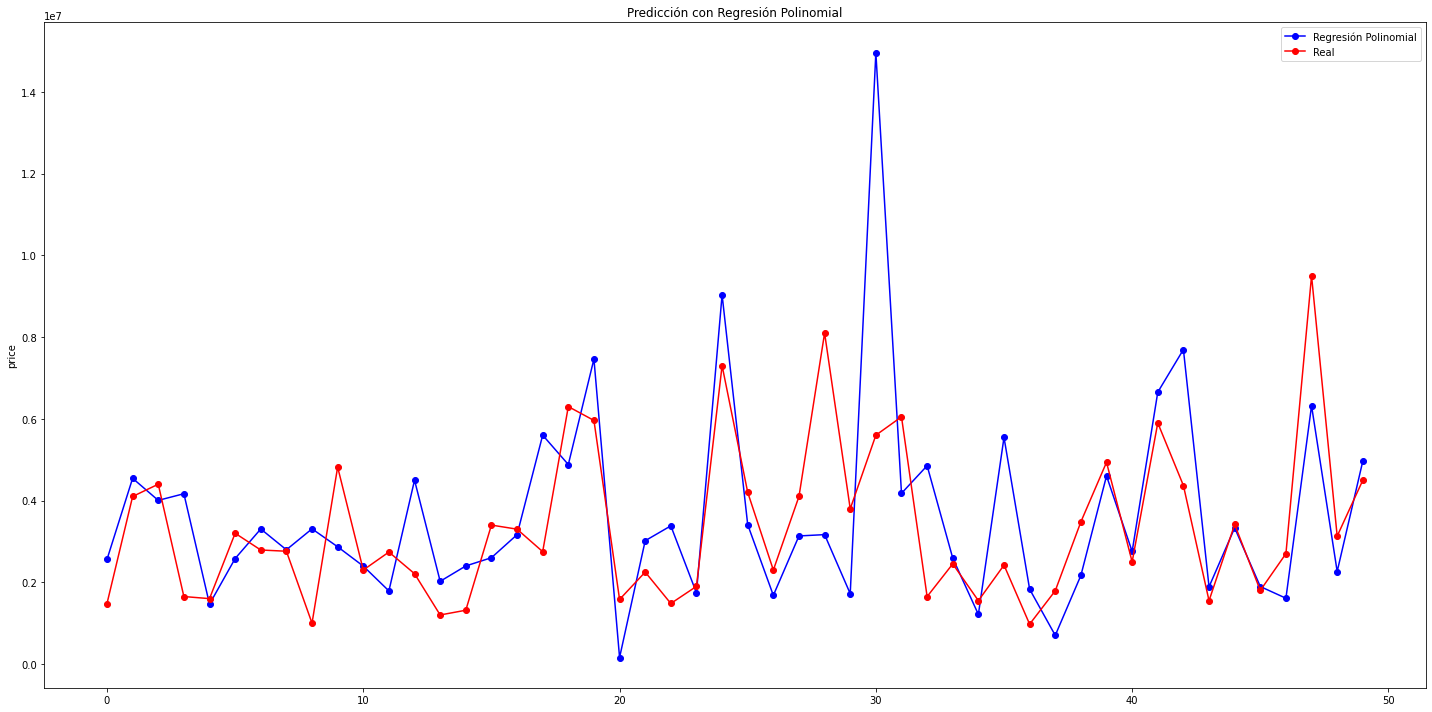

In [94]:
draw_chart(y_val, y_pred, "Predicción con Regresión Polinomial", "Regresión Polinomial")

### **Regresión Ridge**
#### **Entrenamiento (Sin estandarización)**



In [95]:
ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)

Ridge()

In [96]:
ridge_coef = dict(zip(X_train.columns, ridge_reg.coef_))
ridge_coef

{'area': 154868.33845110604,
 'building_type': -305153.02767437906,
 'geo_lat': 161513.66278299456,
 'geo_lon': -16964.517960405476,
 'kitchen_area': 142990.26844323956,
 'level': 81760.08653715104,
 'levels': -80398.88620009799,
 'object_type': -72423.98263651626,
 'region': -210.12294547761525,
 'rooms': -1149565.546930919}

#### **Validación**

In [97]:
y_pred_2 = ridge_reg.predict(X_val)

In [98]:
r2_ridge = r2_score(y_val, y_pred_2)
mse_ridge = mean_squared_error(y_val, y_pred_2)
mae_ridge = mean_absolute_error(y_val, y_pred_2)

print("------------ Ridge ------------")
print(f"R2-score: {r2_ridge:.7f}")
print(f"Residual sum of squares (MSE): {mse_ridge:.5f}")
print(f"Mean absolute error: {mae_ridge:.5f}")

------------ Ridge ------------
R2-score: 0.0155369
Residual sum of squares (MSE): 856346403416418.50000
Mean absolute error: 2766789.01479


#### **Comportamiento de los datos reales vs los datos predecidos**

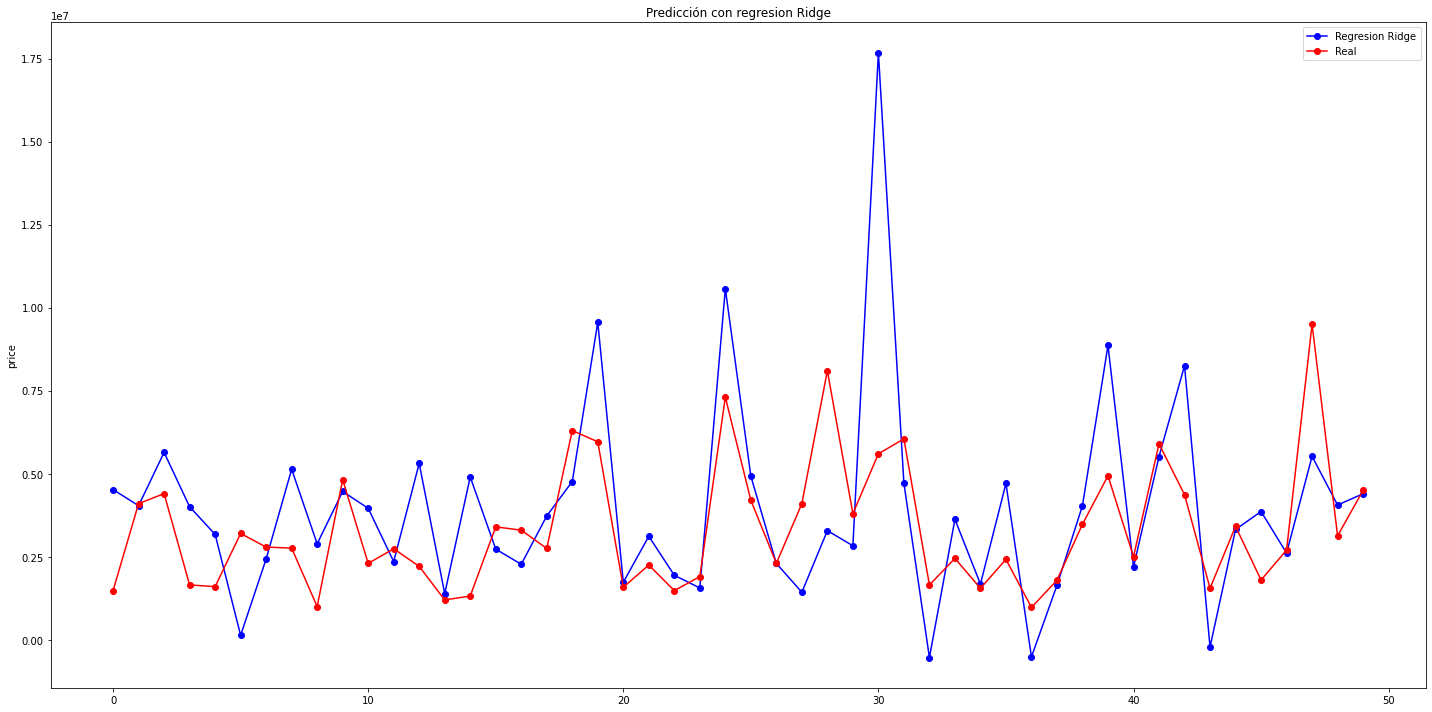

In [99]:
%matplotlib inline
draw_chart(y_val, y_pred_2, "Predicción con regresion Ridge", "Regresion Ridge")

#### **Entrenamiento (Con estandarización)**

In [100]:
pipeline_ridge = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("regressor", Ridge()),
    ],
)

pipeline_ridge.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('regressor', Ridge())])

In [102]:
ridge_coef = dict(zip(X_train.columns, pipeline_ridge.steps[1][1].coef_))
ridge_coef

{'area': 4056059.7952671433,
 'building_type': -351570.00789569266,
 'geo_lat': 801009.0387559393,
 'geo_lon': -344308.56534270145,
 'kitchen_area': 818593.6411814974,
 'level': 399476.47457921866,
 'levels': -514346.0673778117,
 'object_type': -30916.64689338933,
 'region': -672401.6793718407,
 'rooms': -1062709.4272272026}

#### **Validación**

In [103]:
y_pred_2b = pipeline_ridge.predict(X_val)

In [104]:
r2_ridge_s = r2_score(y_val, y_pred_2b)
mse_ridge_s = mean_squared_error(y_val, y_pred_2b)
mae_ridge_s = mean_absolute_error(y_val, y_pred_2b)

print("------------ Ridge (Con estandarización) ------------")
print(f"R2-score: {r2_ridge_s:.7f}")
print(f"Residual sum of squares (MSE): {mse_ridge_s:.5f}")
print(f"Mean absolute error: {mae_ridge_s:.5f}")

------------ Ridge (Con estandarización) ------------
R2-score: 0.0155376
Residual sum of squares (MSE): 856345797915336.87500
Mean absolute error: 2766761.54467


#### **Comportamiento de los datos reales vs los datos predecidos**

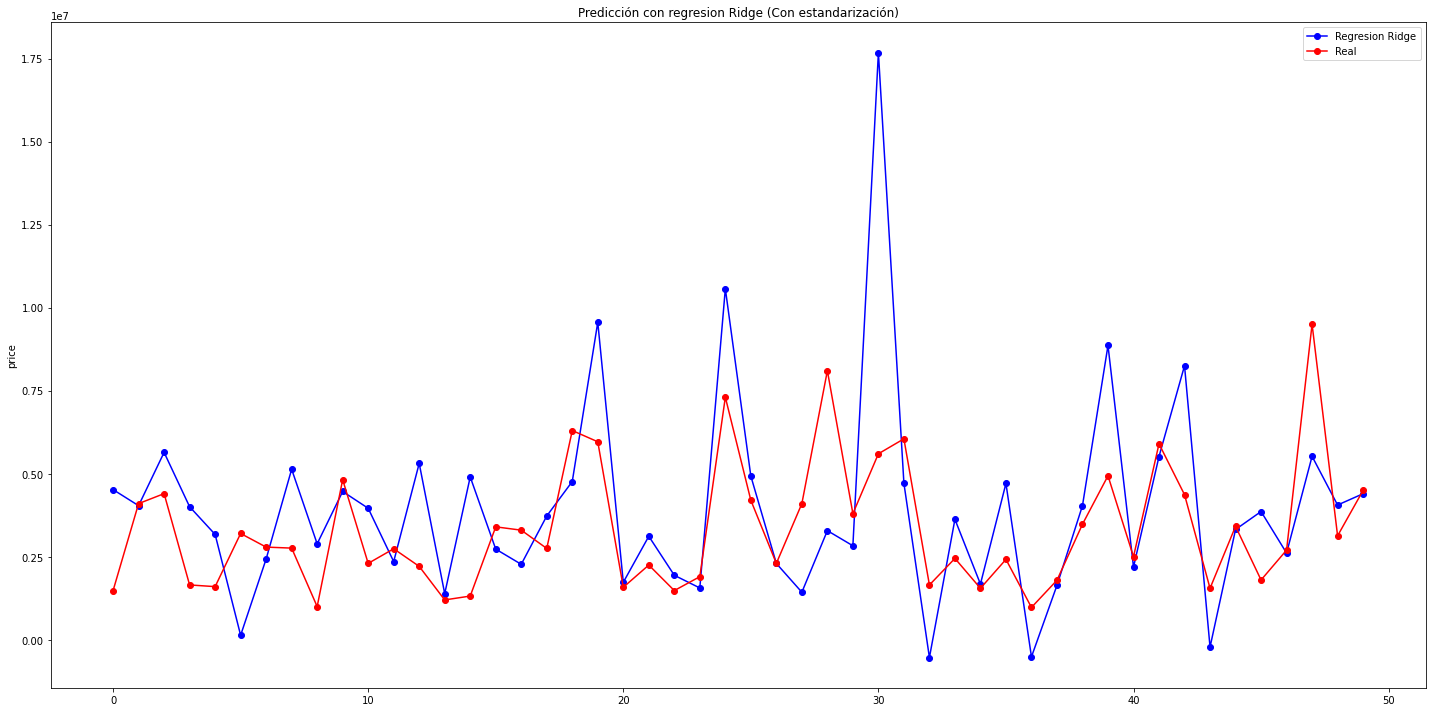

In [105]:
%matplotlib inline
draw_chart(
    y_val,
    y_pred_2b,
    "Predicción con regresion Ridge (Con estandarización)",
    "Regresion Ridge",
)

### **Regresión Lasso**
#### **Entrenamiento (Sin estandarización)**

In [106]:
lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

Lasso()

In [107]:
lasso_coef = dict(zip(X_train.columns, lasso_reg.coef_))
lasso_coef

{'area': 154869.55346860903,
 'building_type': -305157.9267847932,
 'geo_lat': 161513.63259954704,
 'geo_lon': -16964.17659880185,
 'kitchen_area': 142988.99637046753,
 'level': 81760.38430141193,
 'levels': -80399.76019620728,
 'object_type': -72433.09857817208,
 'region': -210.12502766544114,
 'rooms': -1149615.2836025169}

#### **Validación**

In [108]:
y_pred_3 = lasso_reg.predict(X_val)

In [110]:
r2_lasso = r2_score(y_val, y_pred_3)
mse_lasso = mean_squared_error(y_val, y_pred_3)
mae_lasso = mean_absolute_error(y_val, y_pred_3)

print("------------ Lasso ------------")
print(f"R2-score: {r2_lasso:.4f}")
print(f"Residual sum of squares (MSE): {mse_lasso:.5f}")
print(f"Mean absolute error: {mae_lasso:.5f}")

------------ Lasso ------------
R2-score: 0.0155
Residual sum of squares (MSE): 856346517388233.12500
Mean absolute error: 2766791.02678


#### **Comportamiento de los datos reales vs los datos predecidos**

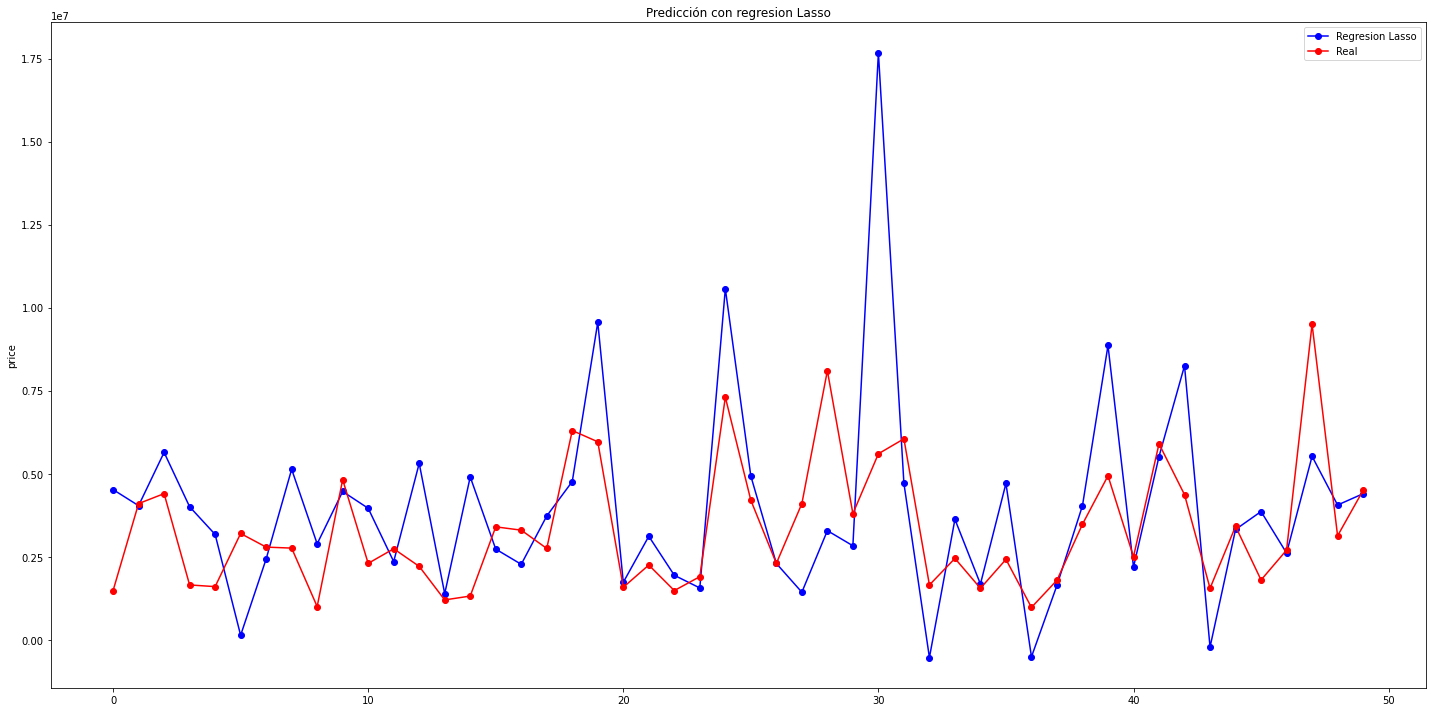

In [111]:
%matplotlib inline
draw_chart(y_val, y_pred_3, "Predicción con regresion Lasso", "Regresion Lasso")

#### **Entrenamiento (Con estandarización)**

In [112]:
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("regressor", Lasso()),
    ],
)

pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('regressor', Lasso())])

In [113]:
lasso_coef = dict(zip(X_train.columns, pipeline.steps[1][1].coef_))
lasso_coef

{'area': 4056279.851197695,
 'building_type': -351579.00150982355,
 'geo_lat': 801028.588377499,
 'geo_lon': -344287.6393498053,
 'kitchen_area': 818522.0262647023,
 'level': 399503.49101314053,
 'levels': -514396.8353988942,
 'object_type': -30908.536493223208,
 'region': -672443.9640513017,
 'rooms': -1062854.3762072562}

#### **Validación**

In [114]:
y_pred_3b = pipeline.predict(X_val)

In [115]:
r2_lasso_s = r2_score(y_val, y_pred_3b)
mse_lasso_s = mean_squared_error(y_val, y_pred_3b)
mae_lasso_s = mean_absolute_error(y_val, y_pred_3b)

print("------------ Lasso (Con estandarización) ------------")
print(f"R2-score: {r2_lasso_s:.7f}")
print(f"Residual sum of squares (MSE): {mse_lasso_s:.5f}")
print(f"Mean absolute error: {mae_lasso_s:.5f}")

------------ Lasso (Con estandarización) ------------
R2-score: 0.0155368
Residual sum of squares (MSE): 856346518738339.12500
Mean absolute error: 2766790.10750


#### **Comportamiento de los datos reales vs los datos predecidos**

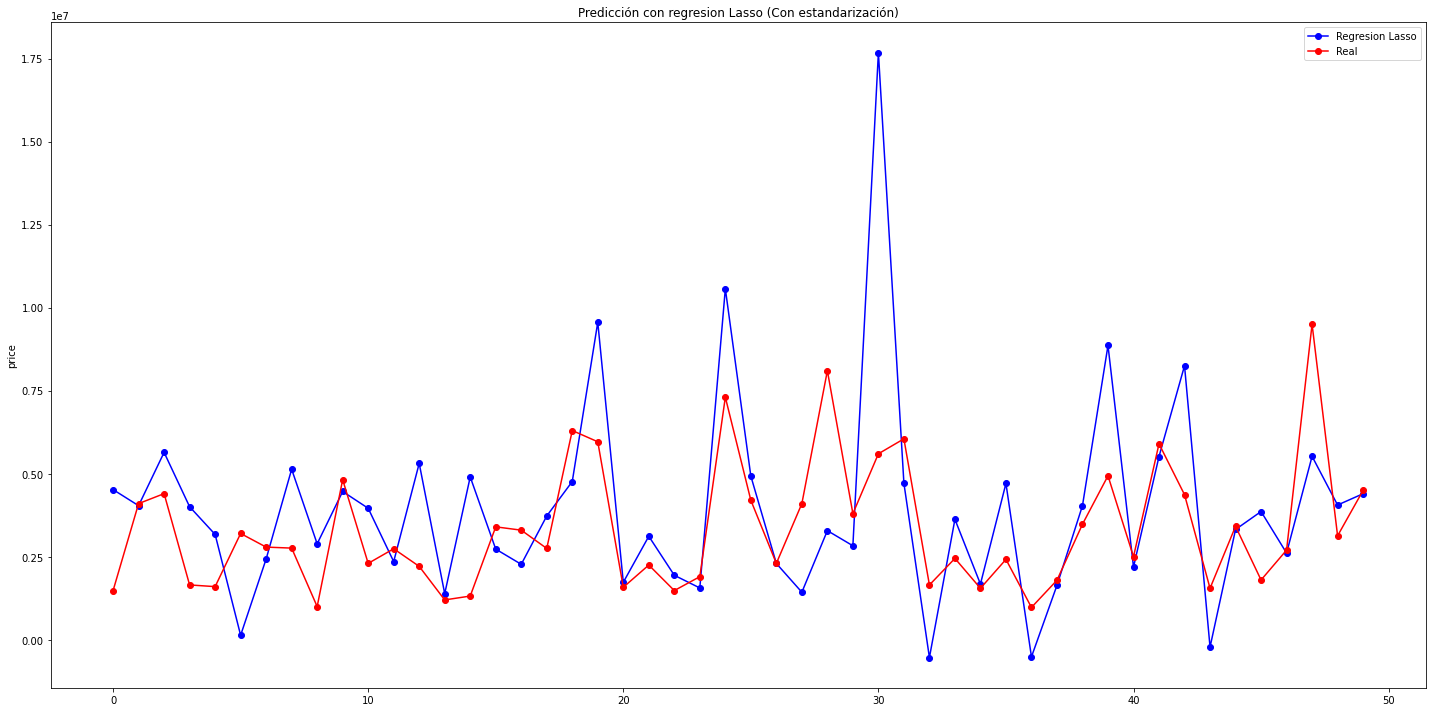

In [116]:
%matplotlib inline
draw_chart(
    y_val,
    y_pred_3b,
    "Predicción con regresion Lasso (Con estandarización)",
    "Regresion Lasso",
)

### **Selección del mejor modelo**
Tabla comparativa con los resultados de las métricas R2, MSE y MAE para los 3 modelos entrenados.

In [117]:
info = {
    "Model": ["Poly Regression", "Ridge", "Ridge (con S)", "Lasso", "Lasso (con S)"],
    "R2": [r2_poly, r2_ridge, r2_ridge_s, r2_lasso, r2_lasso_s],
    "MSE": [mse_poly, mse_ridge, mse_ridge_s, mse_ridge, mse_lasso_s],
    "MAE": [mae_poly, mae_ridge, mae_ridge_s, mae_lasso, mae_lasso_s],
}

print(tabulate(info, headers="keys", tablefmt="fancy_grid"))

╒═════════════════╤═══════════╤═════════════╤═════════════╕
│ Model           │        R2 │         MSE │         MAE │
╞═════════════════╪═══════════╪═════════════╪═════════════╡
│ Poly Regression │ 0.0468936 │ 8.2907e+14  │ 2.71181e+06 │
├─────────────────┼───────────┼─────────────┼─────────────┤
│ Ridge           │ 0.0155369 │ 8.56346e+14 │ 2.76679e+06 │
├─────────────────┼───────────┼─────────────┼─────────────┤
│ Ridge (con S)   │ 0.0155376 │ 8.56346e+14 │ 2.76676e+06 │
├─────────────────┼───────────┼─────────────┼─────────────┤
│ Lasso           │ 0.0155368 │ 8.56346e+14 │ 2.76679e+06 │
├─────────────────┼───────────┼─────────────┼─────────────┤
│ Lasso (con S)   │ 0.0155368 │ 8.56347e+14 │ 2.76679e+06 │
╘═════════════════╧═══════════╧═════════════╧═════════════╛


### **Optimización de hiperparámetros para el mejor modelo**